# Confirmed Cases per day

In [52]:
%matplotlib inline

In [53]:
from typing import List

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import json
import time
import math

In [55]:
try:
    json_data = requests.get("https://coronavirus-tracker-api.herokuapp.com/all").json()
    json.dump(json_data, open(f"coronavirus-tracker-cache-{time.time()}.json", "w"))
except:
    print("Read from cache instead.")

In [56]:
confirmed = pd.DataFrame(json_data['confirmed']['locations'])

In [57]:
states_list = list([
    c for c in
    confirmed[confirmed.country_code == "US"].province.values
    if "," not in c and "Princess" not in c
])

In [58]:
subset_states = states_list

confirmed_subset_states = pd.DataFrame({
    state: pd.Series({
        pd.to_datetime(k): v 
        for k, v in confirmed[confirmed.province == state].history.iloc[0].items()
    }).sort_index() 
    for state in subset_states
})

_states = {
    'Florida': 'green',
    'New York': 'red',
    'California': 'yellow',
    'Washington': 'blue',
    'Maryland': 'orange',
}

In [59]:
state_popn = pd.read_csv("StatePopulations.csv")
state_popn = state_popn.set_index("State Name")
state_abbr = pd.read_csv("StateAbbreviations.csv")

`confirmed_subset_states` is a pandas array with a column for each state and a row for each date.

In [60]:
def plot_states(states: List[str] = None, legend: List[str] = False, data_src = None):
    data_src = data_src if data_src else confirmed_subset_states
    states = states if states else data_src.columns
    with plt.style.context("fivethirtyeight"):
        fig_scale = 2
        plt.figure(figsize=(8*fig_scale, 5*fig_scale))
        for state in states:
            in_legend = (legend is True or (isinstance(legend, list) and state in legend))
            state_data = data_src[state]
            state_data = state_data[state_data > 0]
            if in_legend:
                plt.plot(
                    state_data.keys(), 
                    state_data.values, 
                    label=f"{state} — $T_d$ = {np.round(dt_and_max_cases.loc[state].Td, 2)}",
                    c=_states[state] if state in _states else '#000000'
                )
            else:
                plt.plot(
                    state_data.keys(), 
                    state_data.values, 
                    label=None,
                    color="#000000", alpha=0.02
                )
        plt.legend()
        plt.title("Total Confirmed Cases per State")
        plt.ylabel("Confirmed Cases")
        plt.xlabel("Date")
        
        
def plot_states_density(states: List[str] = None, legend: List[str] = False, data_src = None):
    data_src = data_src if data_src else confirmed_subset_states
    states = states if states else data_src.columns
    with plt.style.context("fivethirtyeight"):
        fig_scale = 2
        plt.figure(figsize=(8*fig_scale, 5*fig_scale))
        for state in states:
            try:
                in_legend = (legend is True or (isinstance(legend, list) and state in legend))
                state_data = data_src[state]
                state_data = state_data[state_data > 0]
                if in_legend:
                    plt.plot(
                        state_data.keys(),
                        state_data.values / state_popn.loc[state]['Population'], 
                        label=f"{state} — $T_d$ = {np.round(dt_and_max_cases.loc[state].Td, 2)}",
                        c=_states[state] if state in _states else '#000000'
                    )
                else:
                    plt.plot(
                        state_data.keys(), 
                        state_data.values / state_popn.loc[state]['Population'], 
                        label=None,
                        color="#000000", alpha=0.02
                    )
            except:
                print(f"Failed to render {state}")
        plt.legend()
        plt.axhspan(0.1, 1.0, alpha=0.3)
        plt.axhspan(0.01, 0.1, alpha=0.1)
        plt.text(pd.Timestamp("2020-03-10"), 1.0, "100%")
        plt.text(pd.Timestamp("2020-03-10"), 0.1, "10%")
        plt.text(pd.Timestamp("2020-03-10"), 0.01, "1%")
        plt.title("Confirmed Cases per State (% of State Population)")
        plt.ylabel("Confirmed Cases (% of total state population)")
        plt.yscale("log")
        plt.xlabel("Date")

def plot_developing_doubling_time(states: List[str] = None, data_src=None):
    data_src = data_src if data_src else confirmed_subset_states
    states = states if states else data_src.columns
    with plt.style.context("fivethirtyeight"):
        fig_scale = 2
        plt.figure(figsize=(8*fig_scale, 5*fig_scale))
        for state in states:
            X = pd.to_numeric(
                confirmed_subset_states[[state]].T.keys() - pd.to_datetime("Jan 1 2020")
            )/millis_per_day
            Y = [
                get_dataset_doubling_period(confirmed_subset_states[[state]][:i])[0][0]
                for i in range(len(confirmed_subset_states[[state]]))
            ]
            data = pd.DataFrame({"X": X, "Y": Y})
            data = data[(data.Y > 0) & (data.Y < 10)]
            plt.plot(
                pd.to_datetime("Jan 1 2020") + pd.to_timedelta(data.X, 'days'), data.Y, label=state,
                c=_states[state] if state in _states else '#000000'
            )
        plt.legend()
    plt.title("Estimated $T_d$ of coronavirus over time, per state (low numbers are worse)")
    plt.ylabel("Doubling time (days)")
    plt.xlabel("Date of measurement")
    plt.show()
            
    

millis_per_day = 60*60*24*1000*1000*1000
def get_dataset_doubling_period(dataset, Td_only=False) -> float:
    dataset = dataset[(dataset.T != 0).any()]
    if len(dataset) == 0 or np.Inf in dataset or 0 in dataset:
        return [[0, 0]]
    results = {}
    for i, state in dataset.T.iterrows():
        state = state[state > 0]
        try:
            results[i] = np.polyfit(
                np.log(state.values), 
                (
                    state.T.keys() - pd.to_datetime("Jan 1 2020")
                ).astype(int) / (millis_per_day), 1
            )
        except Exception as e:
            results[i] = np.array([0,0])
    if Td_only:
        return list(results.values())
    return pd.Series(results)

In [61]:
doubling_times = get_dataset_doubling_period(confirmed_subset_states[states_list])

dt_and_max_cases = pd.DataFrame([doubling_times]).T.join(
    pd.DataFrame(confirmed_subset_states.max().T, columns=["max"])
)
dt_and_max_cases['Td'] = dt_and_max_cases[0].map(lambda x: x[0])
dt_and_max_cases['b'] = dt_and_max_cases[0].map(lambda x: x[1])
dt_and_max_cases = dt_and_max_cases[['max', 'Td', 'b']]

/Users/mateljk1/.pyenv/versions/3.7.7/envs/scripting/lib/python3.7/site-packages/ipykernel_launcher.py:1: RankWarning: Polyfit may be poorly conditioned
  """Entry point for launching an IPython kernel.
/Users/mateljk1/.pyenv/versions/3.7.7/envs/scripting/lib/python3.7/site-packages/numpy/lib/polynomial.py:630: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale


/Users/mateljk1/.pyenv/versions/3.7.7/envs/scripting/lib/python3.7/site-packages/ipykernel_launcher.py:81: RankWarning: Polyfit may be poorly conditioned
/Users/mateljk1/.pyenv/versions/3.7.7/envs/scripting/lib/python3.7/site-packages/ipykernel_launcher.py:81: RankWarning: Polyfit may be poorly conditioned
/Users/mateljk1/.pyenv/versions/3.7.7/envs/scripting/lib/python3.7/site-packages/ipykernel_launcher.py:81: RankWarning: Polyfit may be poorly conditioned
/Users/mateljk1/.pyenv/versions/3.7.7/envs/scripting/lib/python3.7/site-packages/ipykernel_launcher.py:81: RankWarning: Polyfit may be poorly conditioned
/Users/mateljk1/.pyenv/versions/3.7.7/envs/scripting/lib/python3.7/site-packages/ipykernel_launcher.py:81: RankWarning: Polyfit may be poorly conditioned


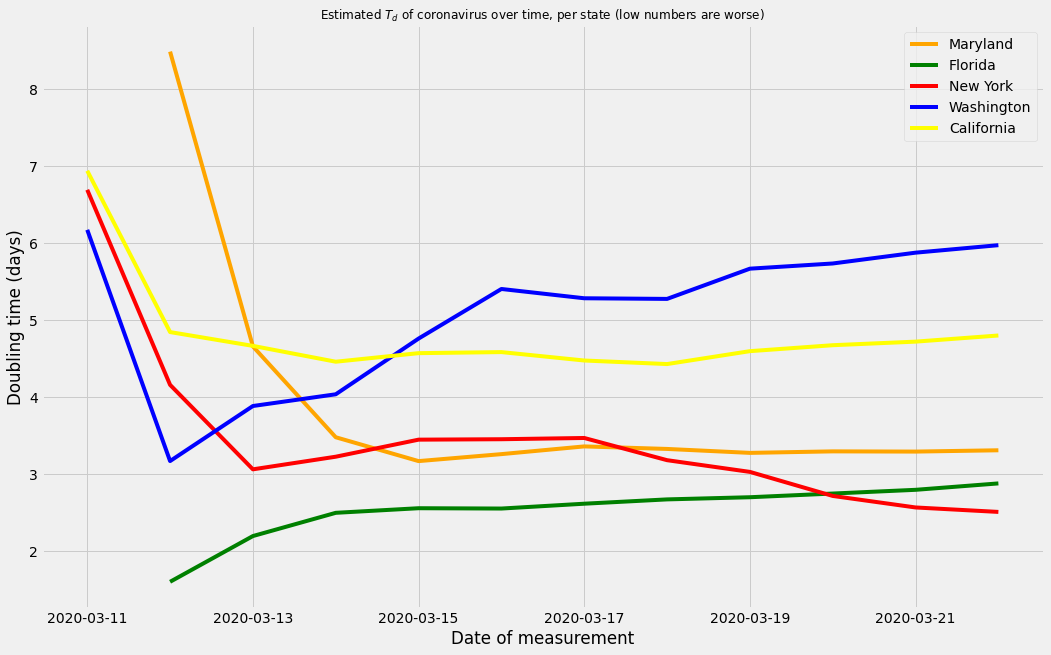

In [62]:
plot_developing_doubling_time(['Maryland', 'Florida', "New York", "Washington", "California"])

Failed to render District of Columbia
Failed to render Puerto Rico
Failed to render Guam
Failed to render Virgin Islands
Failed to render United States Virgin Islands
Failed to render US


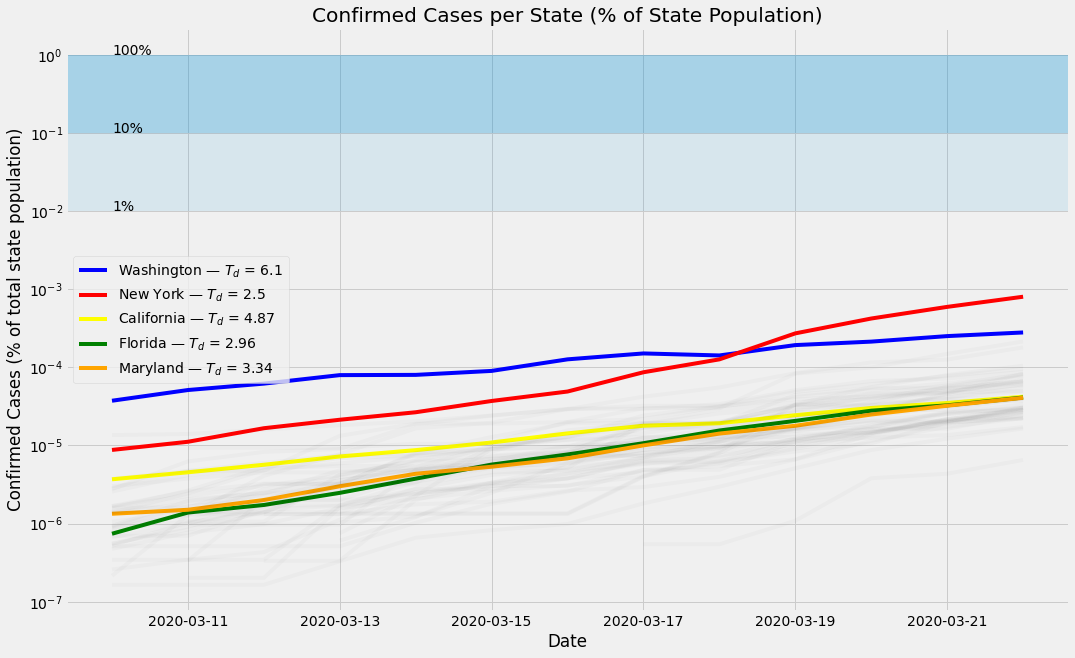

In [63]:
plot_states_density(legend=['Florida', 'New York', 'California', 'Washington', 'Maryland'])

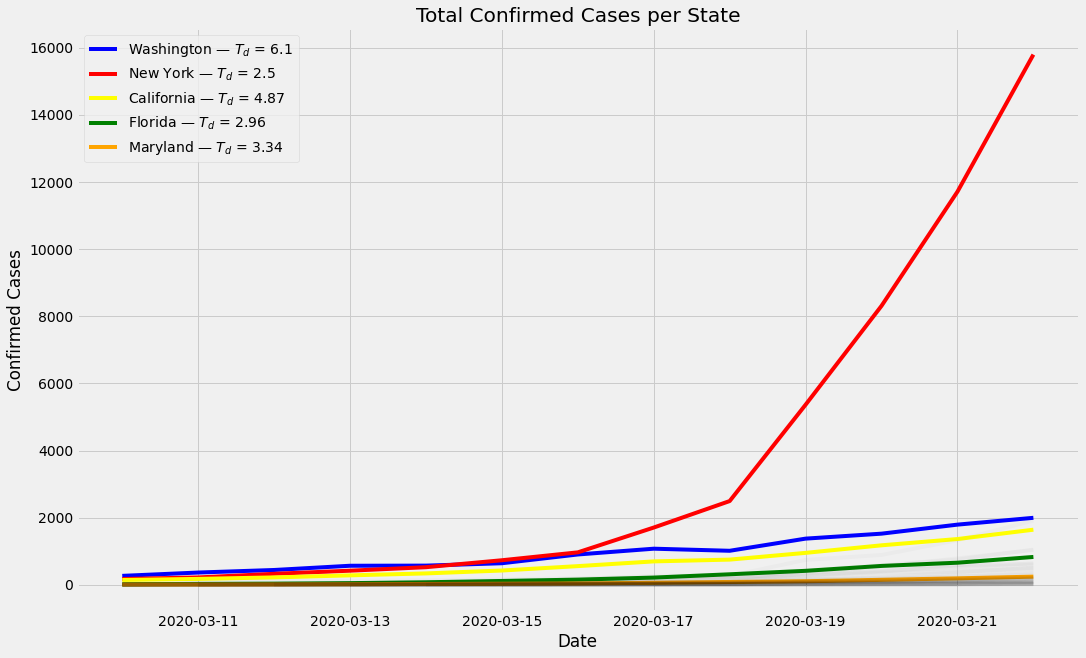

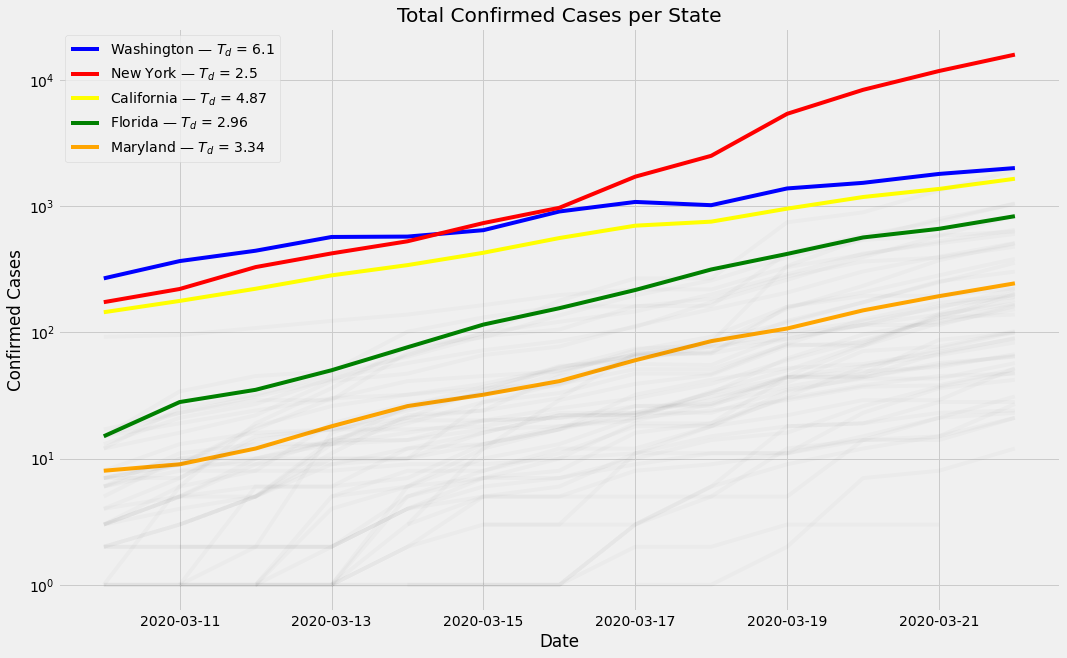

In [64]:
plot_states(legend=[
    'Florida', 'New York', 
    'California', 'Washington', 
    'Maryland'
])
plt.show()

plot_states(legend=[
    'Florida', 'New York', 
    'California', 'Washington', 
    'Maryland'
])
plt.yscale("log")
plt.show()

In [65]:
dt_and_max_cases.describe()

,max,Td,b
count,56.000000,56.000000,56.000000
mean,592.857143,3.612665,62.419192
std,2116.928387,3.025053,11.888461
min,1.000000,0.000000,0.000000
25%,50.250000,2.466316,60.992152
50%,156.500000,2.936584,64.181495
75%,404.750000,3.646541,69.186650
max,15793.000000,22.603480,76.545825


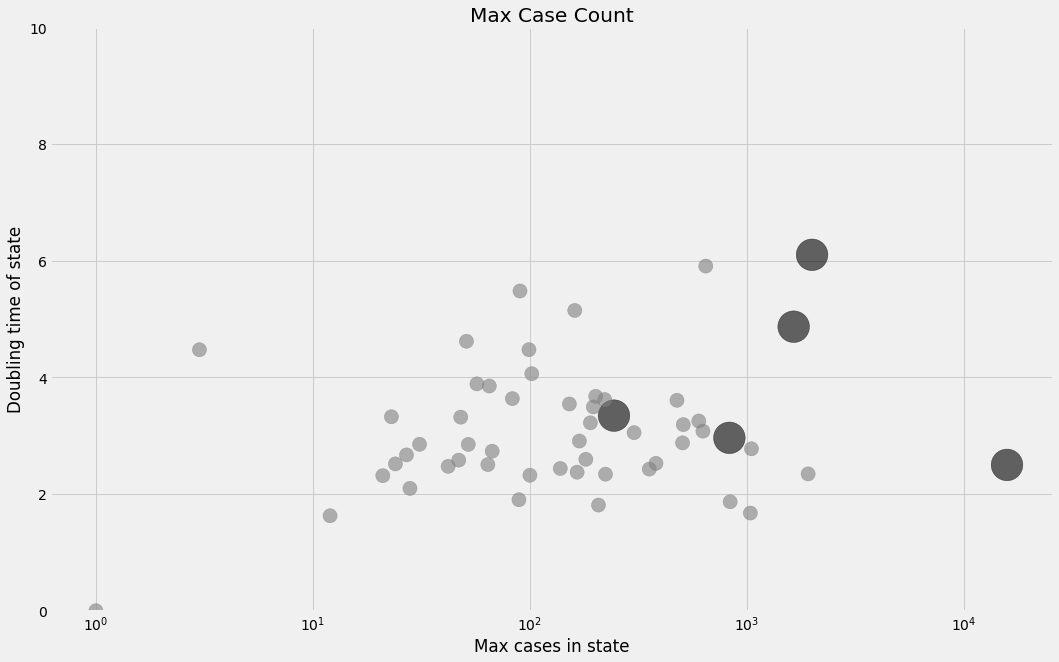

In [66]:
with plt.style.context("fivethirtyeight"):
    fig_scale = 2
    plt.figure(figsize=(8*fig_scale, 5*fig_scale))
    plt.title("Max Case Count")
    plt.xlabel("Max cases in state")
    plt.ylabel("Doubling time of state")
    plt.scatter(
        dt_and_max_cases['max'], 
        dt_and_max_cases.Td,
        s=[
            1000 if i in _states.keys() else 200
            for i, _ in dt_and_max_cases.iterrows()
        ], alpha=0.6,
        c=[
            'black' if i in _states.keys() else 'grey'
            for i, _ in dt_and_max_cases.iterrows()
        ],
    )
    plt.xscale("log")
    plt.ylim(0, 10)

# To learn about another country:

In [67]:
countries = [('usa', 'US'), ('italy', 'IT'), ('india', 'IN'), ('israel', 'IS'), ('china', 'CN'), ('southkorea', 'SK')]

countries = pd.DataFrame({
    country: pd.Series({
        pd.to_datetime(k): v 
        for k, v in confirmed[confirmed.country_code == abbr].iloc[0]['history'].items()
    }).sort_index()
for country, abbr in countries})

In [68]:
get_dataset_doubling_period(countries[['italy']])

italy    [3.6795239789383483, 35.92586958531489]
dtype: object

(array([737446., 737456., 737463., 737470., 737477., 737485., 737492.,
       737499., 737506.]), <a list of 9 Text major ticklabel objects>)


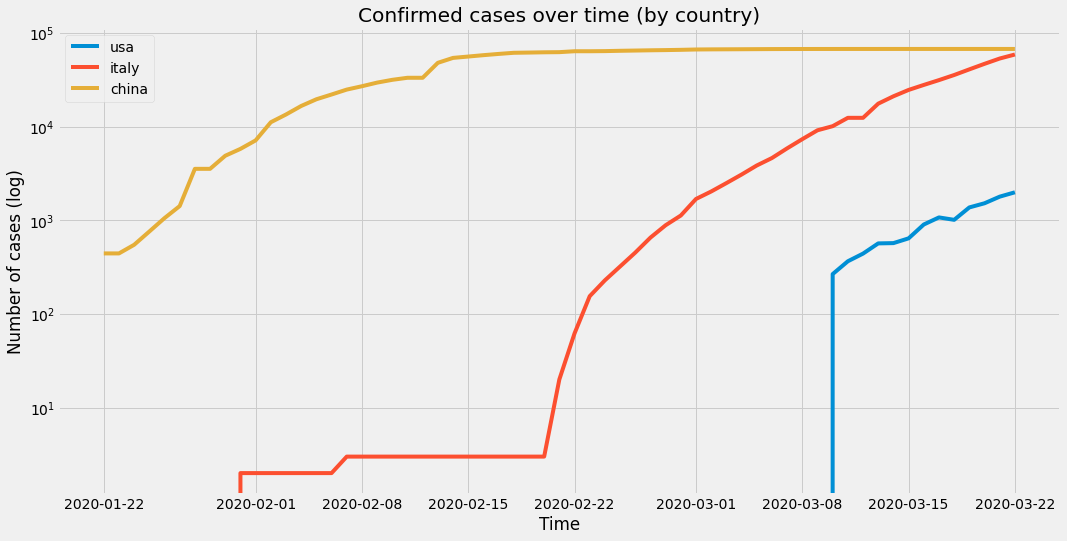

In [69]:
with plt.style.context("fivethirtyeight"):
    plt.figure(figsize=(16, 8))
    plt.plot(countries[['usa']], label='usa')
    plt.plot(countries[['italy']], label='italy')
    plt.plot(countries[['china']], label='china')
    plt.yscale("log")
    plt.title("Confirmed cases over time (by country)")
    plt.ylabel("Number of cases (log)")
    plt.xlabel("Time")
    print(plt.xticks())
    plt.legend()